In [ ]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 45.6 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import packages
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# reading data stored in CSV file into a pandas dataframe
data_df = pd.read_csv('/content/DataSet3.csv')

In [ ]:
data_df.head()

,Unnamed: 0,SMILES string,Homo-lumo band gap,Enthalpy,Specific Heat
0,0,C,0.5048,-40.475117,6.469
1,1,N,0.3399,-56.522082,6.316
2,2,O,0.3615,-76.400922,6.002
3,3,C#C,0.3351,-77.304583,8.574
4,4,C#N,0.3796,-93.408425,6.278


In [ ]:
data_df.drop(columns = ['Unnamed: 0'], inplace=True)

In [ ]:
columns = ['SMILES', 'Hf', 'Enthalpy', 'Cp']
data_df.columns = columns

In [ ]:
data_df.head()

,SMILES,Hf,Enthalpy,Cp
0,C,0.5048,-40.475117,6.469
1,N,0.3399,-56.522082,6.316
2,O,0.3615,-76.400922,6.002
3,C#C,0.3351,-77.304583,8.574
4,C#N,0.3796,-93.408425,6.278


To extract structural fingerprints from SMILES (Simplified Molecular Input Line Entry System) of a molecule, you can use the RDKit library in Python. RDKit is an open-source software development kit for cheminformatics and provides a wide range of functions for working with molecular data.  
In the below code, we first define a SMILES string for the molecule of interest. We then use the Chem.MolFromSmiles() function to convert the SMILES string to a molecule object. Next, we generate a Morgan fingerprint using the AllChem.GetMorganFingerprintAsBitVect() function, which takes the molecule object and two parameters: radius, which defines the radius of the fingerprint and nBits, which defines the length of the fingerprint.

Finally, we convert the fingerprint to a numpy array using the ToBitString() function and print the resulting array.

In [ ]:
# Convert SMILES to fingerprints
data_df['mol'] = data_df['SMILES'].apply(Chem.MolFromSmiles)

radius = 3
nBits = 1024
fps = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in data_df['mol']]
# data_df['fps'] = data_df['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024))
# # converting the fingerprint to numpy array
# fp_array = np.zeros((0,), dtype=np.int8)
# data_df['fps'] = data_df['fps'].apply(lambda x: x.ToBitString(fp_array))

Adding the fingerprints in the dataframe, by saving each bit to one column

In [ ]:
fp_name = [f'Bit_{i}' for i in range(nBits)]
fp_bits = [list(l) for l in fps]
df_morgan = pd.DataFrame(fp_bits, columns=fp_name)

In [ ]:
combined_df = pd.concat([data_df[['Hf', 'Enthalpy', 'Cp']], df_morgan], axis=1)

In [ ]:
combined_df.head()

,Hf,Enthalpy,Cp,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,0.5048,-40.475117,6.469,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.3399,-56.522082,6.316,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.3615,-76.400922,6.002,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.3351,-77.304583,8.574,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.3796,-93.408425,6.278,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50371 entries, 0 to 50370
Columns: 1027 entries, Hf to Bit_1023
dtypes: float64(3), int64(1024)
memory usage: 394.7 MB


In [ ]:
combined_df.describe()

,Hf,Enthalpy,Cp,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
count,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,...,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000
mean,0.243557,-394.494786,28.928091,0.007723,0.075023,0.013202,0.013262,0.051796,0.037442,0.007802,...,0.013182,0.012745,0.018324,0.086677,0.008457,0.560978,0.016259,0.010045,0.007802,0.019654
std,0.048050,43.399019,3.504536,0.087540,0.263432,0.114140,0.114394,0.221616,0.189845,0.087985,...,0.114056,0.112175,0.134122,0.281364,0.091574,0.496273,0.126473,0.099723,0.087985,0.138810
min,0.037600,-675.257561,6.002000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.210000,-421.814718,26.838500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.237900,-399.749890,28.956000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.277200,-364.802696,31.077000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,0.622100,-40.475117,42.733000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# counting the number of NaN values
combined_df.isna().sum().sum()

0

In [ ]:
# train test testation split
train_df, test_df = train_test_split(combined_df, test_size=0.1, random_state=42)

train_df, validation_df = train_test_split(train_df, test_size=0.1, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)

x_train_df, y1_train_df, y2_train_df, y3_train_df = train_df.drop(['Hf', 'Enthalpy', 'Cp'], axis=1).copy(), train_df['Hf'].copy(),  train_df['Enthalpy'].copy(),  train_df['Cp'].copy()
x_valid_df, y1_valid_df, y2_valid_df, y3_valid_df = validation_df.drop(['Hf', 'Enthalpy', 'Cp'], axis=1).copy(), validation_df['Hf'].copy(),  validation_df['Enthalpy'].copy(),  validation_df['Cp'].copy()
x_test_df, y1_test_df, y2_test_df, y3_test_df = test_df.drop(['Hf', 'Enthalpy', 'Cp'], axis=1).copy(), test_df['Hf'].copy(),  test_df['Enthalpy'].copy(),  test_df['Cp'].copy()

**Keras model** - **CNN model** Using the morgan fingerprints

In [ ]:
# model architecture
model = keras.models.Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(1024, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1022, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 511, 64)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 511, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 509, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 254, 64)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 254, 64)           0

In [ ]:
# Compile the model with Mean Squared Error (MSE) loss and Adam optimizer
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.01))


**For 'Hg'**

In [ ]:
# Fit the model with a batch size of 32 for Hg
res1 = model.fit(x_train_df, y1_train_df, epochs=2, validation_data=(x_valid_df, y1_valid_df))

Epoch 1/2
1275/1275 [==============================] - 159s 125ms/step - loss: 7.0479e-04 - val_loss: 5.1210e-04
Epoch 2/2
1275/1275 [==============================] - 158s 124ms/step - loss: 6.3995e-04 - val_loss: 4.3408e-04


In [ ]:
# Evaluate the model
loss1 = model.evaluate(x_test_df, y1_test_df)
print('Test loss for Hg:', loss1)

x_new = x_test_df[:5] # pretend these are new instances
y1_pred = model.predict(x_new)
# print(np.array(y_test_df[:3]))
print(f'Actual values: {np.array(y1_test_df[:5])}; Predicted values: {y1_pred.ravel()}')

158/158 [==============================] - 5s 30ms/step - loss: 4.4804e-04
Test loss for Hg: 0.0004480406641960144
1/1 [==============================] - 0s 190ms/step
Actual values: [0.2227 0.209  0.1381 0.1866 0.1559]; Predicted values: [0.21147113 0.2232575  0.18880372 0.2234745  0.18435971]


**Standard deviation between predicted and actual values - test data**

In [ ]:
# Calculate the standard deviation between predicted and actual values - test data
y1_test_pred = model.predict(x_test_df)
sd = np.std(y1_test_pred - np.array(y1_test_df))
print(f'Standard deviation between actual Tg and predicted Tg in test data = {sd}')

158/158 [==============================] - 3s 21ms/step
Standard deviation between actual Tg and predicted Tg in test data = 0.06151966154691269


**Mean difference between predicted and actual values - test data**

In [ ]:
# Calculating mean difference between predicted and actual values - test data
mean_diff = np.sum(abs(np.subtract(np.array(y1_test_pred).ravel(), np.array(y1_test_df)))) / len(y1_test_pred)
print(f'Mean difference between predicted and actual Tg values in test data = {mean_diff}')

Mean difference between predicted and actual Tg values in test data = 0.016187490553167806


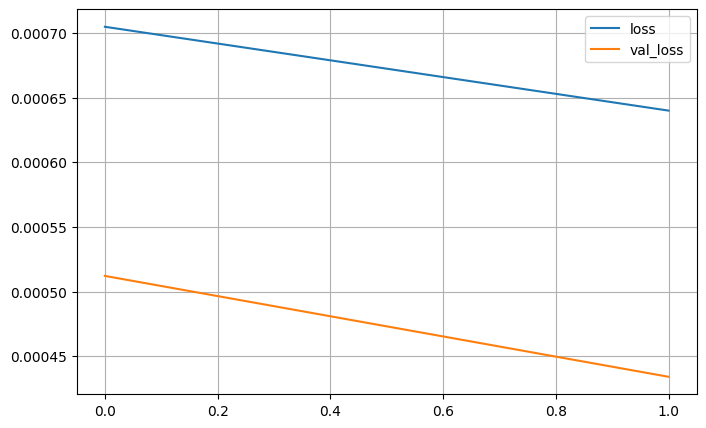

In [ ]:
pd.DataFrame(res1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

**For 'Enthalpy'**

In [ ]:
# Fit the model with a batch size of 32 for Enthalpy
res2 = model.fit(x_train_df, y2_train_df, epochs=2, validation_data=(x_valid_df, y2_valid_df))

Epoch 1/2
1275/1275 [==============================] - 162s 127ms/step - loss: 41556.0430 - val_loss: 11481.2998
Epoch 2/2
1275/1275 [==============================] - 159s 125ms/step - loss: 39839.0312 - val_loss: 9730.3291


In [ ]:
# Evaluate the model
loss2 = model.evaluate(x_test_df, y2_test_df)
print('Test loss for Enthalpy:', loss2)

158/158 [==============================] - 3s 21ms/step - loss: 9594.9053
Test loss for Enthalpy: 9594.9052734375


**For 'Cp'**

In [ ]:
# Fit the model with a batch size of 32 for Cp
res3 = model.fit(x_train_df, y3_train_df, epochs=2, validation_data=(x_valid_df, y3_valid_df))

Epoch 1/2
1275/1275 [==============================] - 160s 126ms/step - loss: 1646.4153 - val_loss: 994.9358
Epoch 2/2
1275/1275 [==============================] - 159s 125ms/step - loss: 966.2494 - val_loss: 945.5037


In [ ]:
# Evaluate the model
loss3 = model.evaluate(x_test_df, y3_test_df)
print('Test loss for Cp:', loss3)

158/158 [==============================] - 4s 25ms/step - loss: 942.9712
Test loss for Cp: 942.97119140625


First, the dataset is loaded containing the SMILES and the dependent variables namely, 'Hg', 'Enthalpy', and 'Cp'. 
SMILES of the molecules are converted into morgan fingerprints. The resulting dataframe containing the morgan fingerprints as the features and the dependent variables. The data is split into training and testing sets using train_test_split() function from scikit-learn.

Next, we define a convolutional neural network (CNN) model using Keras. The model has two convolutional layers each followed by max pooling layers and dropout layers, then two dense layers with a dropout layer in between. The last layer is a single output layer as we want to predict a single numerical value (each output variable is predicted individually).

We compile the model using mean squared error (MSE) loss and the Adam optimizer with a learning rate of 0.01. We then train the model using the fit() function with a batch size of 32 and 50 epochs, and use 10% of the training data for validation. Finally, we evaluate the model on the test set using the evaluate() function and print the test loss.




The CNN model works well for predicting Formation energy.  
Test error for formation energy = 6.11899  
However, the test error for  
 - Enthalpy =  9594.9052   
 - Specific heat = 942.971     
  
However we find that the CNN model didn't work well for predicting enthalpy and specific heat.  
So, we try XGBoost algorithm to model the prediction of them.

### **For 'enthalpy'**

In [ ]:
from xgboost import XGBRegressor

# Define the model
model2 = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)

# Train the model
xgb_res2 = model2.fit(x_train_df, y2_train_df)

# Evaluate the model
score2 = model2.score(x_test_df, y2_test_df)
print('Test score for Enthalpy prediction by XGBoost model:', score2)

Test score for Enthalpy prediction by XGBoost model: 0.6562903006077156


In [ ]:
x_new = x_test_df[:5] # pretend these are new instances
y2_pred = model2.predict(x_new)
# print(np.array(y_test_df[:3]))
print(f'Actual values: {np.array(y2_test_df[:5])}; Predicted values: {y2_pred.ravel()}')

Actual values: [-383.764391 -458.952075 -456.560753 -420.53807  -394.815076]; Predicted values: [-373.50858 -433.95438 -429.9226  -411.8949  -397.7279 ]


**Standard deviation between predicted and actual values - test data**

In [ ]:
# Calculate the standard deviation between predicted and actual values - test data
y2_test_pred = model2.predict(x_test_df)
sd = np.std(y2_test_pred - np.array(y2_test_df))
print(f'Standard deviation between actual Enthalpy and predicted Enthalpy in test data = {sd}')

Standard deviation between actual Enthalpy and predicted Enthalpy in test data = 24.854346827416272


**Mean difference between predicted and actual values - test data**

In [ ]:
# Calculating mean difference between predicted and actual values - test data
mean_diff = np.sum(abs(np.subtract(np.array(y2_test_pred).ravel(), np.array(y2_test_df)))) / len(y2_test_pred)
print(f'Mean difference between predicted and actual enthalpy values in test data = {mean_diff}')

Mean difference between predicted and actual enthalpy values in test data = 17.41113163183904


### **For 'Cp'**

In [ ]:
from xgboost import XGBRegressor

# Define the model
model3 = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)

# Train the model
xgb_res3 = model3.fit(x_train_df, y3_train_df)

# Evaluate the model
score3 = model3.score(x_test_df, y3_test_df)
print('Test score for Cp prediction by XGBoost model:', score3)

Test score for Cp prediction by XGBoost model: 0.5917058500040788


In [ ]:
x_new = x_test_df[:5] # pretend these are new instances
y3_pred = model3.predict(x_new)
# print(np.array(y_test_df[:3]))
print(f'Actual values: {np.array(y3_test_df[:5])}; Predicted values: {y3_pred.ravel()}')

Actual values: [29.11  29.568 26.777 29.111 25.203]; Predicted values: [28.860216 29.114943 27.103693 27.297962 25.886719]


**Standard deviation between predicted and actual values - test data**

In [ ]:
# Calculate the standard deviation between predicted and actual values - test data
y3_test_pred = model3.predict(x_test_df)
sd = np.std(y3_test_pred - np.array(y3_test_df))
print(f'Standard deviation between actual Cp and predicted Cp in test data = {sd}')

Standard deviation between actual Cp and predicted Cp in test data = 2.2580727489732384


**Mean difference between predicted and actual values - test data**

In [ ]:
# Calculating mean difference between predicted and actual values - test data
mean_diff = np.sum(abs(np.subtract(np.array(y3_test_pred).ravel(), np.array(y3_test_df)))) / len(y3_test_pred)
print(f'Mean difference between predicted and actual Cp values in test data = {mean_diff}')

Mean difference between predicted and actual Cp values in test data = 1.6759419424216775


**Results upon using XGBoost for 'Enthalpy' and 'Cp':**  

Test error for enthalpy = 0.65629  
Standard deviation between predicted and actual enthalpy values = 24.8543  
Mean difference between predicted & actual enthalpy values = 17.411  
Actual values: [-383.764391 -458.952075 -456.560753 -420.53807  -394.815076]; Predicted values: [-373.50858 -433.95438 -429.9226  -411.8949  -397.7279 ]  

Test error for specific heat = 0.59170  
Standard deviation between predicted and actual Cp values = 2.258  
Mean difference between predicted and actual CP values = 1.676  
Actual values: [29.11  29.568 26.777 29.111 25.203]; Predicted values: [28.860216 29.114943 27.103693 27.297962 25.886719]   

The results convey that the XGBoost model for predicting enthalpy and specific heat give decentlfairly accurate predictions compared to the CNN model.  

Hence, we finalize the CNN model for predicting formation energy values  
&  
the XGBoost model for predicting enthalpy and specific heat  

### **Parity plots**

**Formation energy**

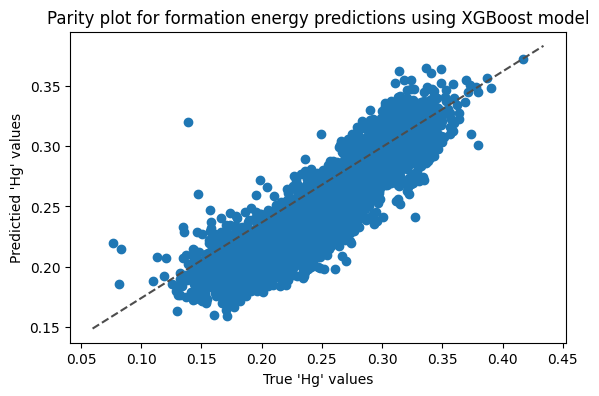

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y1_test_df, y1_test_pred) 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_xlabel("True 'Hg' values")
ax.set_ylabel("Predictied 'Hg' values")
ax.set_aspect("equal")
ax.set_title('Parity plot for formation energy predictions using XGBoost model')
plt.show()

**Enthalpy**

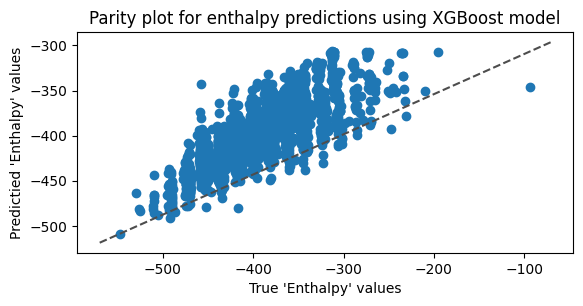

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y2_test_df, y2_test_pred) 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_xlabel("True 'Enthalpy' values")
ax.set_ylabel("Predictied 'Enthalpy' values")
ax.set_aspect("equal")
ax.set_title('Parity plot for enthalpy predictions using XGBoost model')
plt.show()

**Specific heat**

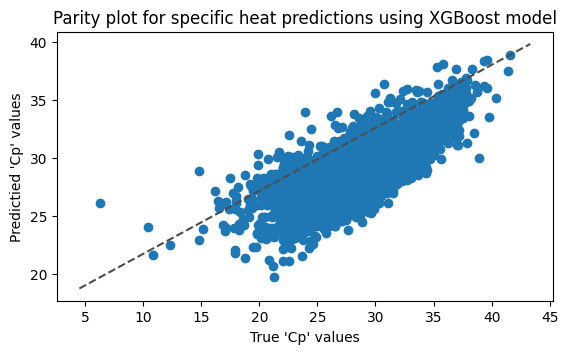

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y3_test_df, y3_test_pred) 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_xlabel("True 'Cp' values")
ax.set_ylabel("Predictied 'Cp' values")
ax.set_aspect("equal")
ax.set_title('Parity plot for specific heat predictions using XGBoost model')
plt.show()